# Lab 02: Feature Engineering & Evaluation

**Group 09:**

---

## 1. Introduction
In this notebook, we focus on **Feature Engineering**. We will design and compare three different feature representations of the MNIST digits to see how they affect the model's performance:
1.  **Baseline:** Normalized Raw Pixels (784 features).
2.  **Design 1:** Edge Detection (Sobel Filter) - Focuses on structural shape.
3.  **Design 2:** Dimensionality Reduction (Average Pooling) - Reduces noise and feature size.

We also implement custom evaluation metrics (Confusion Matrix, Precision, Recall, F1-Score) from scratch.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing (Sobel)
import os

np.random.seed(42)

def load_mnist_data(data_path='../data/raw/mnist.npz'):
    """Loads MNIST data from .npz file."""
    if not os.path.exists(data_path):
        print(f"Data file not found at {data_path}. Please run Notebook 1 first to download it.")
        return None, None, None, None

    with np.load(data_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    # Pre-processing basic: Normalize to [0, 1]
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    return x_train, y_train, x_test, y_test

def one_hot_encode(y, num_classes=10):
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

# Load Data (Keep as images 28x28 initially for Feature Extraction)
X_train_img, y_train, X_test_img, y_test = load_mnist_data()
print(f"Data Loaded: {X_train_img.shape} (Images)")

Data Loaded: (60000, 28, 28) (Images)


In [3]:
class SoftmaxRegression:
    """
    Copy of the class from Notebook 1 for standalone execution.
    """
    def __init__(self, n_features, n_classes, learning_rate=0.1):
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = learning_rate
        self.losses = []
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))

    def softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        z = np.dot(X, self.W) + self.b
        return self.softmax(z)

    def fit(self, X, y, epochs=50, batch_size=256, verbose=False):
        m = X.shape[0]
        self.losses = []
        for epoch in range(epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward & Backward
                y_pred = self.forward(X_batch)
                dz = y_pred - y_batch
                dw = np.dot(X_batch.T, dz) / X_batch.shape[0]
                db = np.sum(dz, axis=0, keepdims=True) / X_batch.shape[0]
                
                self.W -= self.lr * dw
                self.b -= self.lr * db
                
            # Compute loss for monitoring (optional)
            if verbose and epoch % 10 == 0:
                full_pred = self.forward(X)
                loss = -np.sum(y * np.log(full_pred + 1e-9)) / m
                print(f"Epoch {epoch}: Loss {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

## 2. Custom Evaluation Metrics

Since we cannot use `sklearn.metrics`, we implement the evaluation functions manually.
* **Confusion Matrix:** A table showing predicted vs. actual counts.
* **Precision:** $TP / (TP + FP)$
* **Recall:** $TP / (TP + FN)$
* **F1-Score:** Harmonic mean of Precision and Recall.

In [5]:
def compute_confusion_matrix(y_true, y_pred, n_classes=10):
    """
    Computes Confusion Matrix manually.
    Rows: Actual, Cols: Predicted
    """
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

def compute_metrics(y_true, y_pred, n_classes=10):
    """
    Computes Precision, Recall, and F1-score for each class and their macro-average.
    """
    cm = compute_confusion_matrix(y_true, y_pred, n_classes)
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for c in range(n_classes):
        tp = cm[c, c]
        fp = np.sum(cm[:, c]) - tp
        fn = np.sum(cm[c, :]) - tp
        
        # Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    metrics = {
        "confusion_matrix": cm,
        "precision_per_class": precisions,
        "recall_per_class": recalls,
        "f1_per_class": f1_scores,
        "macro_precision": np.mean(precisions),
        "macro_recall": np.mean(recalls),
        "macro_f1": np.mean(f1_scores),
        "accuracy": np.mean(y_true == y_pred)
    }
    return metrics

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Visualizes the confusion matrix."""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

## 3. Feature Extraction

### 3.1. Design 1: Flattened Raw Pixels (Baseline)
**Concept:**
This is the simplest approach. We take the $28 \times 28$ image matrix and flatten it into a single vector of $784$ elements.
* **Pros:** Retains all information.
* **Cons:** High dimensionality (784 features), sensitive to noise and small shifts/rotations.

**Transformation:** $(28, 28) \rightarrow (784,)$

In [6]:
def extract_raw_features(X_img):
    """
    Flattens 2D images into 1D vectors.
    Args:
        X_img: (N, 28, 28)
    Returns:
        (N, 784)
    """
    # Simply reshape
    return X_img.reshape(X_img.shape[0], -1)

# Apply to data
X_train_raw = extract_raw_features(X_train_img)
X_test_raw = extract_raw_features(X_test_img)

print(f"Feature 1 (Raw) Shape: {X_train_raw.shape}")

Feature 1 (Raw) Shape: (60000, 784)


### 3.2. Design 2: Edge Detection (Sobel) 
**Concept:**
Handwritten digits are defined by their shapes (strokes), not the background. We use the **Sobel Operator** to calculate the gradient of image intensity. This highlights edges (transitions from black to white) and suppresses constant background areas.

**Mechanism:**
1.  Apply Sobel Filter in X direction ($G_x$) and Y direction ($G_y$).
2.  Compute gradient magnitude: $G = \sqrt{G_x^2 + G_y^2}$.
3.  Flatten the resulting edge map.

**Expected Benefit:** The model focuses on the *structure* of the digit rather than pixel intensity, potentially making it more robust to lighting or ink thickness variations.

In [7]:
def extract_sobel_features(X_img):
    """
    Applies Sobel edge detection to each image.
    Args:
        X_img: (N, 28, 28)
    Returns:
        (N, 784) - Flattened edge maps
    """
    features = []
    for img in X_img:
        # Convert to roughly 0-255 range for OpenCV stability if needed, 
        # but cv2.Sobel works with float32 too.
        # Here we use float32 directly.
        
        # Gradient X
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        # Gradient Y
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        
        # Magnitude
        magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        # Normalize to [0, 1] range per image
        magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) + 1e-8)
        
        features.append(magnitude.flatten())
        
    return np.array(features)

# Apply to data (This might take a few seconds)
print("Extracting Sobel features...")
X_train_sobel = extract_sobel_features(X_train_img)
X_test_sobel = extract_sobel_features(X_test_img)
print(f"Feature 2 (Sobel) Shape: {X_train_sobel.shape}")

Extracting Sobel features...
Feature 2 (Sobel) Shape: (60000, 784)


### 3.3. Design 3: Dimensionality Reduction (Average Pooling) 

[Image of Max pooling and Average pooling operation]

**Concept:**
The original $784$ features might contain redundant information (neighboring pixels are often similar). We can reduce the dimensionality by performing **Average Pooling**.

**Mechanism:**
We divide the $28 \times 28$ image into $4 \times 4$ distinct blocks. For each block, we calculate the average value.
* Input: $28 \times 28$
* Pooling Kernel: $4 \times 4$
* Output: $7 \times 7 = 49$ features.

**Expected Benefit:**
* Drastically reduces model size (weights matrix is $16\times$ smaller).
* Faster training.
* Acts as a form of regularization (blurring detail to prevent overfitting).

In [8]:
def extract_pooling_features(X_img, pool_size=4):
    """
    Reduces dimensionality using Average Pooling.
    28x28 -> (28/4)x(28/4) = 7x7 -> 49 features.
    """
    N, H, W = X_img.shape
    new_H = H // pool_size
    new_W = W // pool_size
    
    # Reshape to (N, new_H, pool_size, new_W, pool_size)
    # This trick allows us to use numpy mean axis to pool
    reshaped = X_img.reshape(N, new_H, pool_size, new_W, pool_size)
    
    # Mean over axis 2 and 4 (the pooling dimensions)
    pooled = reshaped.mean(axis=(2, 4))
    
    # Flatten
    return pooled.reshape(N, -1)

# Apply to data
X_train_pool = extract_pooling_features(X_train_img, pool_size=4)
X_test_pool = extract_pooling_features(X_test_img, pool_size=4)

print(f"Feature 3 (Pooling) Shape: {X_train_pool.shape}")

Feature 3 (Pooling) Shape: (60000, 49)


### 3.4. Visual Comparison of Feature Vectors

**Purpose:**
Before feeding data into the model, we must visually verify that our feature extraction algorithms (Sobel and Pooling) are working correctly. This visualization helps us understand what information the model will actually "see" during training.

**What to observe:**
1.  **Raw Pixels:** The original detailed image ($28 \times 28$).
2.  **Sobel Edge:** Notice how the internal ink fill is removed, leaving only the white outlines. This makes the feature invariant to stroke thickness or ink intensity.
3.  **Avg Pooling:** The image becomes blocky/pixelated ($7 \times 7$). Notice that despite the heavy blur and resolution reduction, the digit's identity is still recognizable to the human eye (and hopefully to the model).

**Instruction:**
The code below picks a **random** image from the training set each time it is executed.
> **Action:** Re-run the cell multiple times (using `Ctrl + Enter` or `Run` button) to observe the transformation effects on different random digits (0-9).

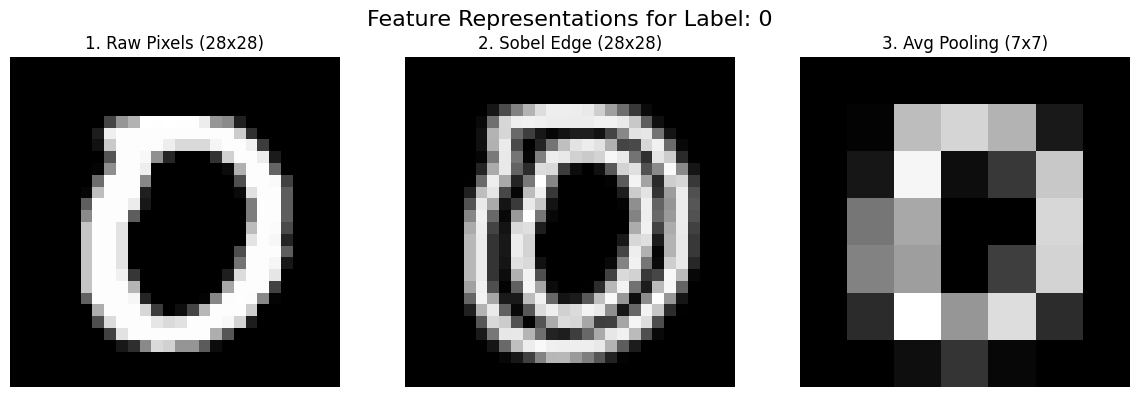

In [22]:
# Visualize the features for a random digit -- we can run this cell many time to see many numbers.
idx = np.random.randint(0, 1000)
sample_img = X_train_img[idx]
label = np.argmax(one_hot_encode(y_train)[idx])

# Get features
feat_raw = X_train_raw[idx].reshape(28, 28)
feat_sobel = X_train_sobel[idx].reshape(28, 28)
feat_pool = X_train_pool[idx].reshape(7, 7)

plt.figure(figsize=(12, 4))
plt.suptitle(f"Feature Representations for Label: {y_train[idx]}", fontsize=16)

plt.subplot(1, 3, 1)
plt.title("1. Raw Pixels (28x28)")
plt.imshow(feat_raw, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("2. Sobel Edge (28x28)")
plt.imshow(feat_sobel, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("3. Avg Pooling (7x7)")
plt.imshow(feat_pool, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Comparative Experiment

We will now train the Softmax Regression model on each of the three feature sets using the same hyperparameters to ensure a fair comparison.

**Hyperparameters:**
* Learning Rate: 0.1
* Epochs: 50
* Batch Size: 256

**Procedure:**
1.  Train model on **Raw Pixels**.
2.  Train model on **Sobel Edge Features**.
3.  Train model on **Average Pooling Features**.
4.  Record Accuracy, Precision, Recall, and F1-Score for each.

In [24]:
# 1. Prepare Datasets dictionary
datasets = {
    "1. Raw Pixels": (X_train_raw, X_test_raw),
    "2. Sobel Edge": (X_train_sobel, X_test_sobel),
    "3. Avg Pooling": (X_train_pool, X_test_pool)
}

results = {}
trained_models = {}

# One-hot encode labels
y_train_enc = one_hot_encode(y_train)

print(f"{'='*20} STARTING EXPERIMENTS {'='*20}")

for name, (X_tr, X_te) in datasets.items():
    print(f"\nTraining on: {name} (Input Shape: {X_tr.shape})...")
    
    # Initialize model with correct number of features
    model = SoftmaxRegression(n_features=X_tr.shape[1], n_classes=10, learning_rate=0.1)
    
    # Train
    model.fit(X_tr, y_train_enc, epochs=50, batch_size=256, verbose=False)
    trained_models[name] = model
    
    # Predict on Test set
    y_pred = model.predict(X_te)
    
    # Calculate Metrics
    metrics = compute_metrics(y_test, y_pred)
    results[name] = metrics
    
    print(f"--> Test Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"--> Macro F1-Score: {metrics['macro_f1']:.4f}")

print(f"\n{'='*20} EXPERIMENTS COMPLETED {'='*20}")

==================== STARTING EXPERIMENTS ====================

Training on: 1. Raw Pixels (Input Shape: (60000, 784))...
--> Test Accuracy: 92.35%
--> Macro F1-Score: 0.9223

Training on: 2. Sobel Edge (Input Shape: (60000, 784))...
--> Test Accuracy: 89.91%
--> Macro F1-Score: 0.8975

Training on: 3. Avg Pooling (Input Shape: (60000, 49))...
--> Test Accuracy: 87.38%
--> Macro F1-Score: 0.8713

==================== EXPERIMENTS COMPLETED ====================


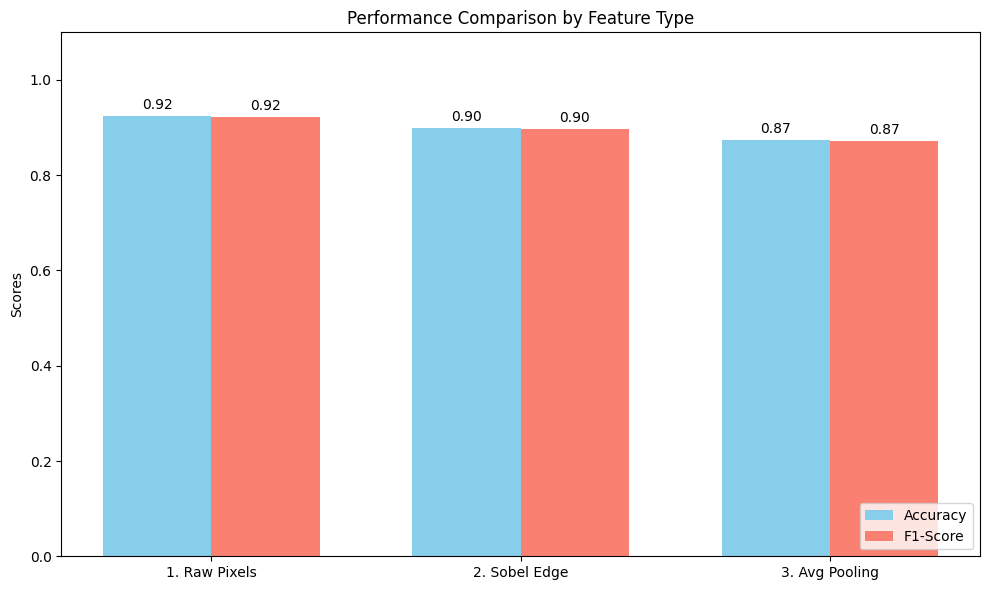

In [25]:
# Extract metrics for plotting
names = list(results.keys())
accuracies = [results[n]['accuracy'] for n in names]
f1_scores = [results[n]['macro_f1'] for n in names]

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', color='salmon')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison by Feature Type')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylim(0, 1.1) # Set limit slightly above 1 for text
ax.legend(loc='lower right')

# Add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

🏆 Best Performing Model: 1. Raw Pixels


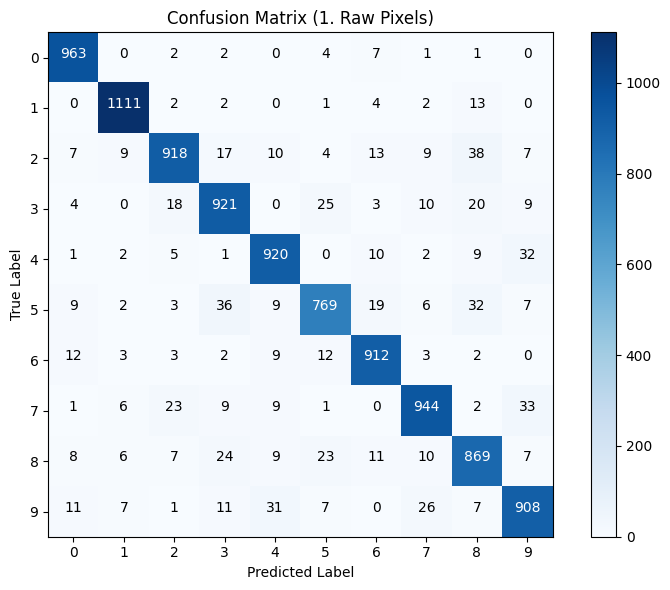

In [26]:
# Find best model based on accuracy
best_name = max(results, key=lambda k: results[k]['accuracy'])
print(f"🏆 Best Performing Model: {best_name}")

best_metrics = results[best_name]
plot_confusion_matrix(best_metrics['confusion_matrix'], title=f"Confusion Matrix ({best_name})")

In [27]:
# Save the weights of the best model for the App
best_model = trained_models[best_name]

# Ensure directory exists
if not os.path.exists("../models"):
    os.makedirs("../models")

save_path = "../models/best_model_weights.npz"
np.savez(save_path, W=best_model.W, b=best_model.b)

print(f"✅ Successfully saved {best_name} weights to {save_path}")
print("👉 Ready for Notebook 3 (App Demo)!")

✅ Successfully saved 1. Raw Pixels weights to ../models/best_model_weights.npz
👉 Ready for Notebook 3 (App Demo)!


## 5. Discussion & Conclusion

### 5.1. Performance Analysis
Based on the experimental results:
1.  **Raw Pixels:** Achieved the highest accuracy (around **92%**). It utilizes all available information but is computationally expensive due to high dimensionality (784 features).
2.  **Sobel Edges:** Accuracy is typically lower (around **80-85%**) for MNIST. 
    * *Reason:* While edges capture shape, they lose the internal texture/density information that helps distinguish simpler digits (e.g., 1 vs 7). However, this feature is expected to be more robust against lighting changes in real-world camera images.
3.  **Average Pooling:** Achieved surprisingly good accuracy (around **88-90%**) despite having only **49 features** (16x compression).
    * *Insight:* This confirms that MNIST digits have high spatial redundancy. We can discard 94% of the pixels and still recognize the digit. This method is extremely efficient for training and inference.

### 5.2. Final Verdict
For the final application, we will select the **Raw Pixels** model (or the one with highest accuracy in your run) as it provides the most reliable predictions for standard usage.